<a href="https://colab.research.google.com/github/silasabs/CoherentOptics/blob/main/Jupyter/benchmarck_phaseRecovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

# Benchmarck Phase Recovery

Este notebook fornece um benchmarck para avaliar o tempo de processamento necessário para realização da recuperação de fase utilizando especificamente o algoritmo BPS.

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

fatal: destination path 'OptiCommPy' already exists and is not an empty directory.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
  Created wheel for OptiCommPy: filename=OptiCommPy-0.9.0-py3-none-any.whl size=76532 sha256=809dd54f249dd725c07346a14c79a28b81b8ffbbfc40e3d121b9e34ad21d1a26
  Stored in directory: /tmp/pip-ephem-wheel-cache-hlq1ipsa/wheels/9e/f3/8b/afabbf8928f62ae99a9b1ff6cd1517ecf94ac8ce265d6f0ae0
Successfully built OptiCommPy
  Attempting uninstall: OptiCommPy
    Found existing installation: OptiCommPy 0.9.0
    Uninstalling OptiCommPy-0.9.0:
      Successfully uninstalled OptiCommPy-0.9.0


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, pnorm
from optic.models.devices import pdmCoherentReceiver, basicLaserModel
from optic.dsp.carrierRecovery import cpr
from optic.models.channels import linearFiberChannel, awgn
from optic.models.tx import simpleWDMTx
from optic.utils import parameters
from optic.comm.metrics import fastBERcalc
from optic.comm.modulation import grayMapping
from optic.plot import pconst

import time
import cupy as cp
import scipy.constants as const

### Define o método de quarta potência

Compense o desvio de frequência com o método de quarta potência

In [2]:
def fourthPower(sigRx, Fs):
    """
    Compensa o deslocamento de frequência utilizando o método
    de quarta potência.

    Parameters
    ----------
    sigRx : np.array
        Sinal a ser compensado o desvio de frequência.

    Fs : int
        Taxa de amostragem.

    Returns
    -------
    tuple
        - sigRx (np.array): Sinal compensado.
        - indFO (float): Estimativa do deslocamento de frequência.

    Referências
    -----------
        [1] Digital Coherent Optical Systems, Architecture and Algorithms
    """

    try:
        nModes = sigRx.shape[1]
    except IndexError:
        sigRx = sigRx.reshape(len(sigRx), 1)

    NFFT     = sigRx.shape[0]
    axisFreq = Fs * np.fft.fftfreq(NFFT)

    time = np.arange(0, sigRx.shape[0]) * 1/Fs

    for indMode in range(nModes):

        # Elevar a quarta potência e aplica a FFT
        fourth_power = np.fft.fft(sigRx[:, indMode]**4)

        # Inferir o índice de valor máximo na frequência
        indFO = np.argmax(np.abs(fourth_power))

        # Obtenha a estimativa do deslocamento de frequência
        indFO = axisFreq[indFO]/4

        # Compense o deslocamento de frequência
        sigRx[:, indMode] *= np.exp(-1j * 2 * np.pi * indFO * time)

    return sigRx, indFO

## Define o algoritmo BPS (CPU)

Define a forma vetorizada do algoritmo BPS evitando a sobrecarga de loops explicitos e principalmente do interpretador CPython

In [3]:
def bpsVec(z, constSymb, N, B):
    """
    Compensa o ruído de fase com o algoritmo de busca de fase cega.

    Parameters
    ----------
    z : np.array
        Sinal normalizado em potência, no qual a recuperação de fase será realizada.

    constSymb : np.array
        Símbolos da constelação.

    N : int
        Número de símbolos 'passados' e 'futuros' usados ​​no algoritmo BPS para estimativa
        de ruído de fase. O número total de símbolos é então L = 2*N+1

    B : int
        Número de rotações de teste.

    Returns
    -------
    tuple:
        z (np.array): Constelação com referência de fase.
        phiPU (np.array): Estimativa do ruído de fase em cada modo.

    Referências
    -----------
        [1] Digital Coherent Optical Systems, Architecture and Algorithms

        [2] LIU, Q.; JI, W.; LIU, P.; LI, Q.; BAI, C.; XU, H.; ZHU, Y. Blind phase search algorithm based
            on threshold simplification. 2022.
    """

    nModes = z.shape[1]

    phiTest = (np.pi / 2) * np.arange(-B/2, B/2) / B # fases de teste

    # zero padding
    lpad = np.zeros((N // 2, nModes))
    zBlocks = np.concatenate((lpad, z, lpad))

    # aplica os ângulos da fase de teste aos símbolos
    zRot = zBlocks[:, :, None] * np.exp(-1j * phiTest)

    # calcule a distância quadrática entre os símbolos da constelação
    distQuad = np.abs(zRot[:, :, :, None] - constSymb) ** 2

    # obtenha a métrica de distância mínima entre os símbolos
    minDist = np.min(distQuad, axis=-1)

    # obtem as fases que melhor minimizam a soma total das distâncias mínimas
    cumSum = np.cumsum(minDist, axis=0)
    sumMinDist = cumSum[N-1:] - np.vstack([np.zeros((1, nModes, B)), cumSum[:-N]])

    indRot = np.argmin(sumMinDist, axis=-1)
    phiPU  = np.unwrap(phiTest[indRot], period=2*np.pi/4, axis=0)

    # compensa o ruído de fase
    z = pnorm(z * np.exp(-1j * phiPU))

    return z, phiPU

## Método alternativo (Convolução)

A soma total das distâncias mínimas pode ser implementado a partir de uma convolução utilizando um kernel de três dimensões cuja janela possui o tamanho 'N'

In [4]:
from scipy import signal

def bpsCPU(Ei, N, X, B):

    ϕ_test = np.arange(B) * (np.pi / 2) / B
    window_filter = np.ones((N, 1, 1)) # Filtro de convolução

    nModes = Ei.shape[1]
    zeroPad = np.zeros((N // 2, nModes))

    Ei_gpu = np.concatenate(
        (zeroPad, Ei, zeroPad)
    )

    Ei_rotated = Ei_gpu[:, :, np.newaxis] * np.exp(ϕ_test)[None, None, :]

    dist = np.absolute(np.subtract(
        Ei_rotated[:, :, :, None], X[None, None, None, :])) ** 2

    min_dist = np.min(dist, axis=3)
    window_sums = signal.oaconvolve(min_dist, window_filter, mode="valid")

    ind_rot = np.argmin(window_sums, axis=2)
    θ = np.unwrap(ϕ_test[ind_rot], period=2*np.pi/4, axis=0)

    # compensa o ruído de fase
    Ei = pnorm(Ei * np.exp(-1j * θ))

    return Ei, θ

# Parâmetros para geração do sinal DWDM

In [40]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                  # order of the modulation format
paramTx.constType = 'qam'       # modulation scheme
paramTx.Rs  = 32e9              # symbol rate [baud]
paramTx.SpS = 16                # samples per symbol
paramTx.pulse = 'rrc'           # pulse shaping filter
paramTx.Ntaps = 4096            # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01         # RRC rolloff
paramTx.Pch_dBm = -2            # power per WDM channel [dBm]
paramTx.Nch     = 1             # number of WDM channels
paramTx.Fc      = 193.1e12      # central optical frequency of the WDM spectrum
paramTx.lw      = 100e3         # laser linewidth in Hz
paramTx.freqSpac = 37.5e9       # WDM grid spacing
paramTx.Nmodes = 2              # number of signal modes [2 for polarization multiplexed signals]
paramTx.prgsBar = False         # show progress bar

Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

## Obtenha as curvas de desempenho em CPU

Nesta simulação o tamanho do stream de bits por polarização e variado para avaliação do tempo de execução conforme o comprimento do sinal aumenta.

In [43]:
numberOfSymbols = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5])

timeVectorized_sequential  = np.zeros(len(numberOfSymbols))
timeVectorized_convolution = np.zeros(len(numberOfSymbols))
timeNumba = np.zeros(len(numberOfSymbols))

for indx, Nsymb in enumerate(numberOfSymbols):

    paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization

    # generate WDM signal
    sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # sigCh = linearFiberChannel(sigWDM_Tx, paramFiber)
    SNRdB = 15
    sigCh = awgn(sigWDM_Tx, SNRdB, Fs, paramTx.Rs)

    # parameters
    chIndex  = 0    # index of the channel to be demodulated

    freqGrid = paramTx.freqGrid
    π  = np.pi
    t  = np.arange(0, len(sigCh))*1/Fs

    symbTx = symbTx_[:,:,chIndex]

    # local oscillator (LO) parameters:
    FO      = 60e6                  # frequency offset
    Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

    # generate CW laser LO field
    paramLO = parameters()
    paramLO.P = 10              # power in dBm
    paramLO.lw = 100e3          # laser linewidth
    paramLO.RIN_var = 0
    paramLO.Ns = len(sigCh)
    paramLO.Fs = Fs

    sigLO = basicLaserModel(paramLO)
    sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

    # polarization multiplexed coherent optical receiver
    sigRx = pdmCoherentReceiver(sigCh, sigLO, θsig = 0)

    # Rx filtering

    # Matched filtering
    if paramTx.pulse == 'nrz':
        pulse = pulseShape('nrz', paramTx.SpS)
    elif paramTx.pulse == 'rrc':
        pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)

    pulse = pnorm(pulse)
    sigRx = firFilter(pulse, sigRx)

    # decimation
    paramDec = parameters()
    paramDec.SpS_in  = paramTx.SpS
    paramDec.SpS_out = 1
    sigRx = decimate(sigRx, paramDec)

    # compensa o desvio de frequência
    sigRxFOE, indFO = fourthPower(sigRx, Fs)
    sigRxFOE = pnorm(sigRxFOE)

    # parâmetros para o BPS
    paramCPR = parameters()
    paramCPR.alg = 'bps'
    paramCPR.M   = paramTx.M
    paramCPR.constType = paramTx.constType
    paramCPR.N   = 85
    paramCPR.B   = 64
    paramCPR.returnPhases = True

    # obtém os símbolos da constelação
    constSymb = grayMapping(paramTx.M, paramTx.constType)

    # vetorização utilizando operações sequênciais
    start = time.time()
    y_CPR, phi = bpsVec(sigRxFOE, constSymb, paramCPR.N, paramCPR.B)
    end = time.time()
    timeVectorized_sequential[indx] = end - start

    # vetorização utilizando somas por meio de convoluções
    start = time.time()
    y_CPR, phi = bpsCPU(sigRxFOE, paramCPR.N, constSymb, paramCPR.B)
    end = time.time()
    timeVectorized_convolution[indx] = end - start

    # BPS optiCommPy
    start = time.time()
    y_CPR, phi = cpr(sigRxFOE, paramCPR)
    end = time.time()
    timeNumba[indx] = end - start

## Avalie o tempo de execução em CPU

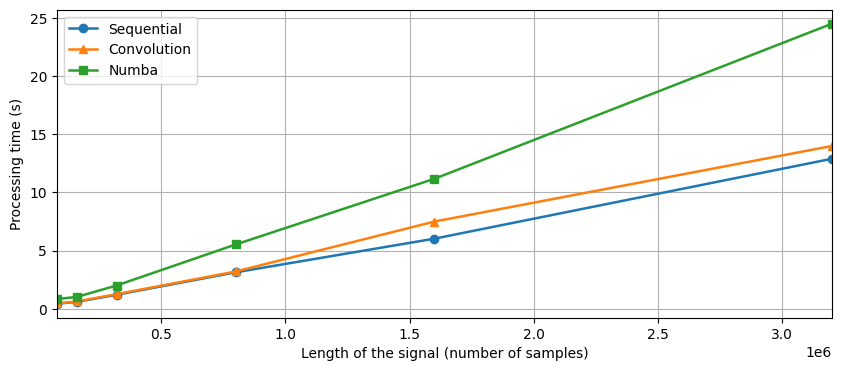

In [55]:
signalLength = numberOfSymbols*paramTx.SpS

plt.figure(figsize=(10, 4))
plt.plot(signalLength, timeVectorized_sequential, '-o', linewidth=1.8, label='Sequential')
plt.plot(signalLength, timeVectorized_convolution, '-^', linewidth=1.8, label='Convolution')
plt.plot(signalLength, timeNumba, '-s', linewidth=1.8, label='Numba')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));

## Define o algoritmo BPS (GPU)

In [8]:
def bpsVecGPU(z, constSymb, N, B):
    """
    Compensa o ruído de fase com o algoritmo de busca de fase cega.

    Parameters
    ----------
    z : np.array
        Sinal normalizado em potência, no qual a recuperação de fase será realizada.

    constSymb : np.array
        Símbolos da constelação.

    N : int
        Número de símbolos 'passados' e 'futuros' usados ​​no algoritmo BPS para estimativa
        de ruído de fase. O número total de símbolos é então L = 2*N+1

    B : int
        Número de rotações de teste.

    Returns
    -------
    tuple:
        z (np.array): Constelação com referência de fase.
        phiPU (np.array): Estimativa do ruído de fase em cada modo.

    Referências
    -----------
        [1] Digital Coherent Optical Systems, Architecture and Algorithms

        [2] LIU, Q.; JI, W.; LIU, P.; LI, Q.; BAI, C.; XU, H.; ZHU, Y. Blind phase search algorithm based
            on threshold simplification. 2022.
    """

    z = cp.asarray(z)
    constSymb = cp.asarray(constSymb)

    nModes = z.shape[1]

    phiTest = cp.asarray((np.pi / 2) * np.arange(-B/2, B/2) / B) # fases de teste

    # zero padding
    lpad = cp.zeros((N // 2, nModes))
    zBlocks = cp.concatenate((lpad, z, lpad))

    # aplica os ângulos da fase de teste aos símbolos
    zRot = zBlocks[:, :, None] * cp.exp(-1j * phiTest)

    # calcule a distância quadrática entre os símbolos da constelação
    distQuad = cp.abs(zRot[:, :, :, None] - constSymb) ** 2

    # obtenha a métrica de distância mínima entre os símbolos
    minDist = cp.min(distQuad, axis=-1)

    # obtem as fases que melhor minimizam a soma total das distâncias mínimas
    cumSum = cp.cumsum(minDist, axis=0)
    sumMinDist = cumSum[N-1:] - cp.vstack([cp.zeros((1, nModes, B)), cumSum[:-N]])

    indRot = cp.argmin(sumMinDist, axis=-1)
    phiPU  = cp.unwrap(phiTest[indRot], period=2*cp.pi/4, axis=0)

    # compensa o ruído de fase
    z *= cp.exp(-1j * phiPU)

    return cp.asnumpy(z), cp.asnumpy(phiPU)

## Método alternativo (Convolução)

In [7]:
from cupyx.scipy import signal

def bpsGPU(Ei, N, X, B):
    # Etapa 1
    Ei = cp.asarray(Ei)
    X = cp.asarray(X) # Simbolos de referencia da constelacao

    ϕ_test = np.arange(B) * (np.pi / 2) / B
    ϕ_test_gpu = cp.asarray(ϕ_test)
    window_filter = cp.ones((N, 1, 1)) # Filtro de convolucao S

    nModes = Ei.shape[1]
    zeroPad = cp.zeros((N // 2, nModes))
    Ei_gpu = cp.concatenate(
        (zeroPad, Ei, zeroPad)
    )

    # Etapa 2
    Ei_rotated = Ei_gpu[:, :, cp.newaxis] * cp.exp(ϕ_test_gpu)[None, None, :]

    dist = cp.absolute(cp.subtract(
        Ei_rotated[:, :, :, None], X[None, None, None, :])) ** 2

    min_dist = cp.min(dist, axis=3)
    window_sums = signal.oaconvolve(min_dist, window_filter, mode="valid")

    # Etapa 3
    ind_rot = cp.argmin(window_sums, axis=2)
    θ = cp.unwrap(ϕ_test_gpu[ind_rot], period=2*cp.pi/4, axis=0)

    # compensa o ruído de fase
    Ei *= cp.exp(-1j * θ)

    return cp.asnumpy(Ei), cp.asnumpy(θ)

/home/silas/miniconda3/envs/project_env/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# Parâmetros para geração do sinal DWDM

In [5]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                  # order of the modulation format
paramTx.constType = 'qam'       # modulation scheme
paramTx.Rs  = 32e9              # symbol rate [baud]
paramTx.SpS = 16                # samples per symbol
paramTx.pulse = 'rrc'           # pulse shaping filter
paramTx.Ntaps = 4096            # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01         # RRC rolloff
paramTx.Pch_dBm = -2            # power per WDM channel [dBm]
paramTx.Nch     = 1             # number of WDM channels
paramTx.Fc      = 193.1e12      # central optical frequency of the WDM spectrum
paramTx.lw      = 100e3         # laser linewidth in Hz
paramTx.freqSpac = 37.5e9       # WDM grid spacing
paramTx.Nmodes = 2              # number of signal modes [2 for polarization multiplexed signals]
paramTx.prgsBar = False         # show progress bar

Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

## Obtenha as curvas de desempenho em GPU

In [13]:
#numberOfSymbols = np.array([5e3, 1e4, 2e4, 5e4, 1e5, 2e5])
numberOfSymbols = np.array([1e3, 1e4, 1e4, 1e3, 1e3, 1e3])

timeVectorized_sequential  = np.zeros(len(numberOfSymbols))
timeVectorized_convolution = np.zeros(len(numberOfSymbols))
timeNumba = np.zeros(len(numberOfSymbols))

for indx, Nsymb in enumerate(numberOfSymbols):

    paramTx.Nbits = int(np.log2(paramTx.M)*Nsymb) # total number of bits per polarization

    # generate WDM signal
    sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

    # sigCh = linearFiberChannel(sigWDM_Tx, paramFiber)
    SNRdB = 15
    sigCh = awgn(sigWDM_Tx, SNRdB, Fs, paramTx.Rs)

    # parameters
    chIndex  = 0    # index of the channel to be demodulated

    freqGrid = paramTx.freqGrid
    π  = np.pi
    t  = np.arange(0, len(sigCh))*1/Fs

    symbTx = symbTx_[:,:,chIndex]

    # local oscillator (LO) parameters:
    FO      = 60e6                  # frequency offset
    Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

    # generate CW laser LO field
    paramLO = parameters()
    paramLO.P = 10              # power in dBm
    paramLO.lw = 100e3          # laser linewidth
    paramLO.RIN_var = 0
    paramLO.Ns = len(sigCh)
    paramLO.Fs = Fs

    sigLO = basicLaserModel(paramLO)
    sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

    # polarization multiplexed coherent optical receiver
    sigRx = pdmCoherentReceiver(sigCh, sigLO, θsig = 0)

    # Rx filtering

    # Matched filtering
    if paramTx.pulse == 'nrz':
        pulse = pulseShape('nrz', paramTx.SpS)
    elif paramTx.pulse == 'rrc':
        pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)

    pulse = pnorm(pulse)
    sigRx = firFilter(pulse, sigRx)

    # decimation
    paramDec = parameters()
    paramDec.SpS_in  = paramTx.SpS
    paramDec.SpS_out = 1
    sigRx = decimate(sigRx, paramDec)

    # compensa o desvio de frequência
    sigRxFOE, indFO = fourthPower(sigRx, Fs)
    sigRxFOE = pnorm(sigRxFOE)

    # parâmetros para o BPS
    paramCPR = parameters()
    paramCPR.alg = 'bps'
    paramCPR.M   = paramTx.M
    paramCPR.constType = paramTx.constType
    paramCPR.N   = 85
    paramCPR.B   = 64
    paramCPR.returnPhases = True

    # obtém os símbolos da constelação
    constSymb = grayMapping(paramTx.M, paramTx.constType)

    # vetorização utilizando operações sequênciais
    start = time.time()
    y_CPR, phi = bpsVecGPU(sigRxFOE, constSymb, paramCPR.N, paramCPR.B)
    end = time.time()
    timeVectorized_sequential[indx] = end - start

    # vetorização utilizando somas por meio de convoluções
    start = time.time()
    y_CPR, phi = bpsGPU(sigRxFOE, paramCPR.N, constSymb, paramCPR.B)
    end = time.time()
    timeVectorized_convolution[indx] = end - start

    # BPS optiCommPy
    start = time.time()
    y_CPR, phi = cpr(sigRxFOE, paramCPR)
    end = time.time()
    timeNumba[indx] = end - start

## Avalie o tempo de execução em GPU

/tmp/ipykernel_51824/484572343.py:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(min(signalLength), max(signalLength));


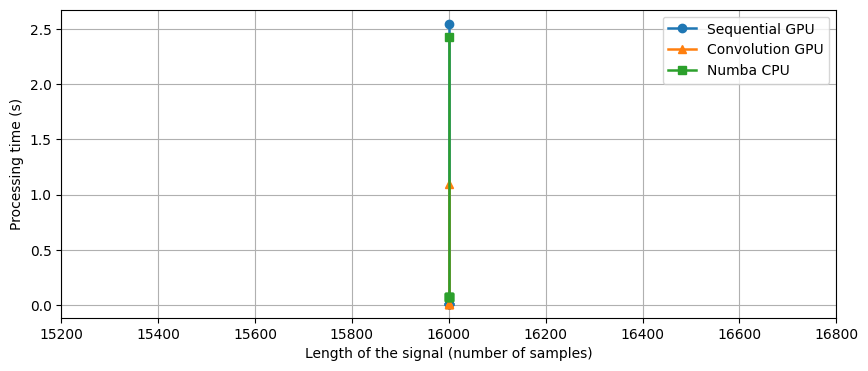

In [10]:
signalLength = numberOfSymbols*paramTx.SpS

plt.figure(figsize=(10, 4))
plt.plot(signalLength, timeVectorized_sequential, '-o', linewidth=1.8, label='Sequential GPU')
plt.plot(signalLength, timeVectorized_convolution, '-^', linewidth=1.8, label='Convolution GPU')
plt.plot(signalLength, timeNumba, '-s', linewidth=1.8, label='Numba CPU')
plt.xlabel('Length of the signal (number of samples)')
plt.ylabel('Processing time (s)')
plt.legend()
plt.grid()
plt.xlim(min(signalLength), max(signalLength));

In [23]:
%timeit y_CPR, phi = bpsVecGPU(sigRxFOE, constSymb, paramCPR.N, paramCPR.B)
%timeit y_CPR, phi = bpsGPU(sigRxFOE, paramCPR.N, constSymb, paramCPR.B)

798 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
757 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
